## Influential people's tweets 

The idea of this part of project is to explore how influential people (politicians, journalists, singers, actors, etc.) from different countries used Twitter during the coronavirus pandemic. This task is meant to show how covid actually affected communication on a semantic level, by promoting hashtags and usage of certain words. For the begining, we decide to focus on our homelands countries to have better understanding of each tweets.

In [2]:
import pandas as pd
import numpy as np

import re
import json
import string
from datetime import datetime, timedelta

import translators as ts

# Natural language processing libraries
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Twitter library
import tweepy

#Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Importing helper functions
from helpers import *

<br/>
We are using intervention data (from the given dataset coronawiki) in order to define periods of interest to analyse tweets for each country.

In [3]:
# Importing intervention dates for each country
data_path = './data/'

interventions = pd.read_csv(data_path + 'interventions.csv', delimiter=',', 
                            parse_dates=['1st case','1st death','School closure',
                                         'Public events banned','Lockdown','Mobility','Normalcy'])

interventions.set_index('lang', inplace=True)
interventions.head()

,1st case,1st death,School closure,Public events banned,Lockdown,Mobility,Normalcy
lang,,,,,,,
fr,2020-01-24,2020-02-14,2020-03-14,2020-03-13,2020-03-17,2020-03-16,2020-07-02
da,2020-02-27,2020-03-12,2020-03-13,2020-03-12,2020-03-18,2020-03-11,2020-06-05
de,2020-01-27,2020-03-09,2020-03-14,2020-03-22,2020-03-22,2020-03-16,2020-07-10
it,2020-01-31,2020-02-22,2020-03-05,2020-03-09,2020-03-11,2020-03-11,2020-06-26
nl,2020-02-27,2020-03-06,2020-03-11,2020-03-24,NaT,2020-03-16,2020-05-29


We are loading dataset which provides us with dates and the number of clicks on wikipedia pages (from mobile phones and computers) of different topics during pandemic.

In [4]:
# Importing pagelogs time series
data_path = './data/'
with open(data_path+'aggregated_timeseries.json','r') as file:
    pagelogs_time_series = json.load(file)
    
pagelogs_time_series.keys()

dict_keys(['ja.m', 'it', 'da.m', 'tr', 'no.m', 'en', 'sr', 'tr.m', 'en.m', 'no', 'sv', 'nl.m', 'nl', 'da', 'de', 'fr.m', 'ca.m', 'de.m', 'ko.m', 'fi.m', 'sr.m', 'ja', 'fr', 'fi', 'ca', 'it.m', 'sv.m', 'ko'])

<br/>
We are starting our analysis by defining lists containing the names of the analysed countries and the spoken languages in those contries. We will focus on Europian countires from the given dataset.

In [5]:
# List of countires and langugeges spoken in this countries
countries = ['FR','DK','DE','IT','NL','NO','SE','RS','FI','GB']
languages = ['fr','da','de','it','nl','no','sv','sr','fi','en']

<br/>
For the first stage, we will focus on retrieving tweets of influential people from Serbia and Italy (our homelands) for the easier verification of the results.

In [6]:
# List of Twitter accounts of influental people from different countries
serbian_influential_people = ['avucic', 'SerbianPM', 'DraganDjilas', 'MarinikaTepic', 'JugoslavCosic',
                              'futomaki', 'VladoGeorgiev', 'brankica_st', 'OAmidzic']

italian_influential_people = ['matteorenzi', 'matteosalvinimi', 'GiorgiaMeloni', 'GiuseppeConteIT',
                              'Corriere', 'SkyTG24', 'LauraPausini', 'ValeYellow46', 'lorenzojova', 'Pontifex_it']

In [9]:
# reading bearer tokens which we need to access Twitter API
with open(data_path+'BearerTokens.json','r') as file:
    bearer_tokens = json.load(file)

In [10]:
def getTwitterUsers(client, usernames):
    """
    Function which retrieving users from 
    Twitter based on usernames
    
    Arguments:
        client : Twitter API v2 Client
        usernames : list of account usernames
    
    Returns:
        users: list of users - id, name, username
    """
    
    users = []
    for username in usernames:
        users.append(client.get_user(username=username))
    return users

In [11]:
# defining client which enables connection with Twitter API
client = tweepy.Client(bearer_token=bearer_tokens["maja"], wait_on_rate_limit=True)

# getting users accounts from twitter
serbian_users = getTwitterUsers(client, serbian_influential_people)
italian_users = getTwitterUsers(client, italian_influential_people)

for user in serbian_users: print(user.data.id, user.data.name, user.data.username)

356450858 Александар Вучић avucic
3036495555 Aна Брнабић SerbianPM
205153283 Dragan Djilas DraganDjilas
834073582514888710 Marinika Tepić MarinikaTepic
2814717661 Jugoslav Ćosić JugoslavCosic
181338564 Marija Serifovic futomaki
41577631 Vlado Georgiev - Barba VladoGeorgiev
1087237020 Brankica Stankovic brankica_st
324198256 ognjen amidzic OAmidzic


<br/>
We want to retrieve tweets from different periods during pandemic, but mostly focusing on weeks preceding intervention days or period with peeks in number of new cases and people's deaths. As an example, we are starting with period three weeks before lockdown in each country.

In [12]:
# Defining period of interest for each country. Dates refered to 3 weeks before the first lockdown
lockdown_dates =  [interventions.loc[lang, 'Lockdown'] for lang in languages]

period_per_countries = {}
for idx,country in enumerate(countries):
    lang = languages[idx]
    dates = [datetime.strptime(date.split()[0], '%Y-%m-%d')  for date in list(pagelogs_time_series[lang]['sum'].keys())]
    dates = [date for date in dates if (lockdown_dates[idx] - date < timedelta(21)) and 
             (lockdown_dates[idx] - date >  timedelta(0))]
    period_per_countries[country] = dates
    
# e.g. three weeks before lockdown in Serbia and Italy
print('Serbia',period_per_countries['RS'][0],'-',period_per_countries['RS'][-1])
print('Italy',period_per_countries['IT'][0],'-',period_per_countries['IT'][-1])

Serbia 2020-03-01 00:00:00 - 2020-03-20 00:00:00
Italy 2020-02-20 00:00:00 - 2020-03-10 00:00:00


<br/>
Now, we want to create dataframe which will contain tweets from influential people from different countries. Each row will contain tweet id, country and languge of tweet, id of user which posted that tweet, orginal text of tweet and its translation to english, date when tweeet is posted and context annotation retrieved from Twitter API.

<br/>
Let's load our dataset with tweets.

In [13]:
# this dataframe is created by calling function 'getTweets' from helpers.py
influential_people_tweets = pd.read_csv('./output/influential_people_tweets.csv', delimiter=',')
influential_people_tweets.head()

,Unnamed: 0,id,country_code,lang,user,tweet_text_orginal,tweet_text_en,tweet_date,context_annotations
0,0,1240013952861511680,RS,sr,Response(data=<User id=356450858 name=Александ...,Поносни смо на наше пријатељство.\r\nНикада не...,we are proud of our friendship we will never f...,2020-03-17 20:35:39+00:00,[]
1,1,1239873649999523845,RS,sr,Response(data=<User id=356450858 name=Александ...,Бескрајно хвала на свему нашој кинеској браћи ...,infinitely thank you for all our chinese broth...,2020-03-17 11:18:08+00:00,"[{'domain': {'id': '123', 'name': 'Ongoing New..."
2,2,1239310408760074240,RS,sr,Response(data=<User id=356450858 name=Александ...,"Предаја није, никада није била и никада неће б...",the surrender is not it was never and will nev...,2020-03-15 22:00:01+00:00,[]
3,3,1238813645385187328,RS,sr,Response(data=<User id=356450858 name=Александ...,"Pадимо, боримо се и урадићемо све што треба. С...",we fall we fight and we will do whatever you n...,2020-03-14 13:06:03+00:00,[]
4,4,1237796648161599491,RS,sr,Response(data=<User id=356450858 name=Александ...,"Одлуке доноси струка, не политика.\r\nХвала на...",decisions make a profession not politics thank...,2020-03-11 17:44:52+00:00,[]


<br/>
For each country we would like to recognise to which topics tweets are related, what are most common used words in tweets and to check sentyment of the tweets. All of this can be useful to understand the way communication has changed during the pandemic and impacted people.


In [14]:
# Libray to infer the topics discussed in each tweet
from empath import Empath
lexicon = Empath()


After reading the categories offered by empath library at https://github.com/Ejhfast/empath-client/blob/master/empath/data/categories.tsv, we report the ones we decide to use.

In [15]:
topics = ['help','medical_emergency','health','government','school','kill','art','play','computer',
         'home','business','religion','sports','death','military','music','science','fun','economics',
         'technology','philosophy','geography','tv','architecture']

emotions = ["suffering","optimism","fear","sadness","joy","anger","pain","negative_emotion","positive_emotion",
           "happiness"]

Using Empath library we want to check to which topics tweets from period three weeks before lockdown are mostly related. We will plot result to two countries, Serbia and Italy.

In [18]:
# function for plotting topic discussed in tweets
def plotTweetsTopics(country_code, country_name, topics, influential_people_tweets):
    """
    Function which plots topic discussed in tweets
    
    Arguments:
        country_code: code of country from which we are retrieving tweets
        country_name: name of country from which we are retrieving tweets
        topics: list of topics
        influential_people_tweets: dataframe with tweets
    """
    
    # We infer the topics discussed in the retrieved tweets
    tweets_from_country = influential_people_tweets.loc[influential_people_tweets['country_code']==country_code, 
                                                        'tweet_text_en']
     # plot only if we have some data from country
    if len(tweets_from_country) > 0:
        classified_topics = pd.DataFrame([lexicon.analyze(tweets_from_country.str.cat(sep = ' '),
                                                      categories = topics, 
                                                      normalize = True)], index = [country_code]).T

        classified_topics = classified_topics.sort_values(by = [country_code], ascending = False)
        classified_topics.reset_index(inplace = True)
        
        fig,ax = plt.subplots(1)

        sns.barplot(data = classified_topics, x = country_code, y = 'index')

        plt.xlabel('Normalized Score')
        plt.ylabel('Topics', fontsize = 14)
        plt.title('Topics discussed in ' + country_name + ' during the 3 weeks preceding the official lockdown')
        plt.show()

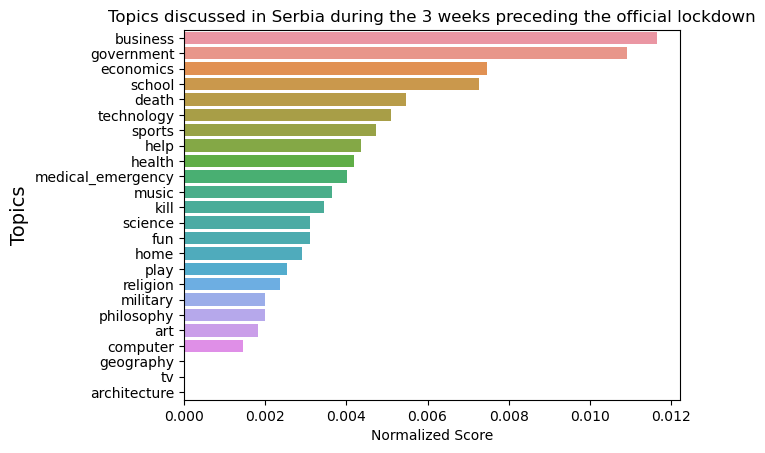

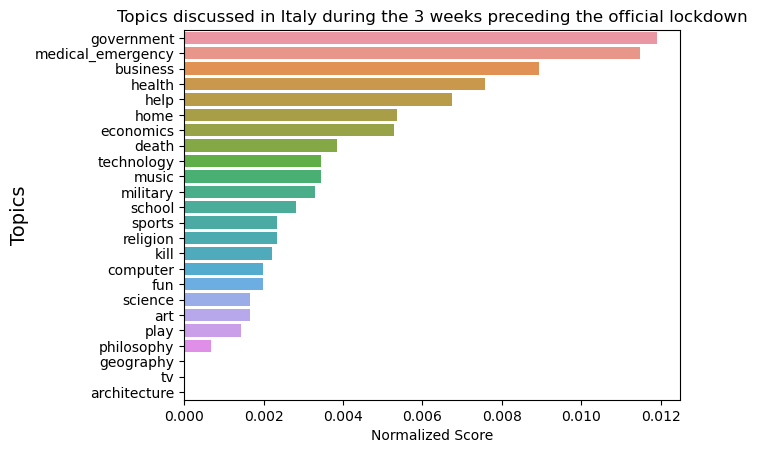

In [19]:
# plotting topic discussed in Serbia and Italy 3 weeks precedign the lockdown
plotTweetsTopics('RS', 'Serbia', topics, influential_people_tweets)
plotTweetsTopics('IT', 'Italy', topics, influential_people_tweets)

Using Empath library we want to check to which topics tweets from period three weeks before lockdown are mostly related. We will plot result to two countries, Serbia and Italy.

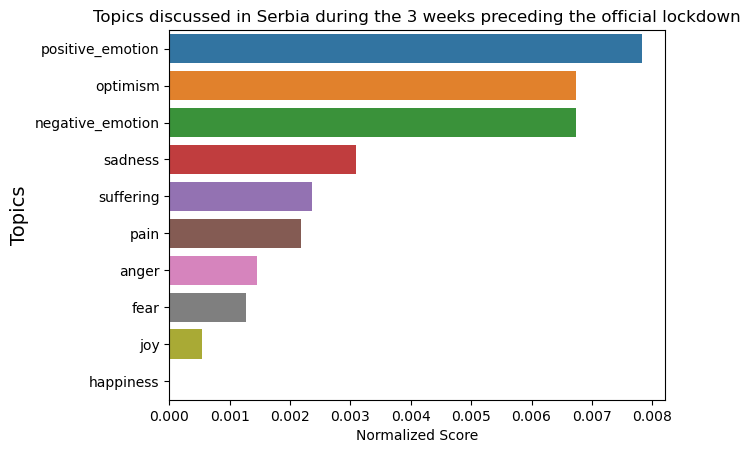

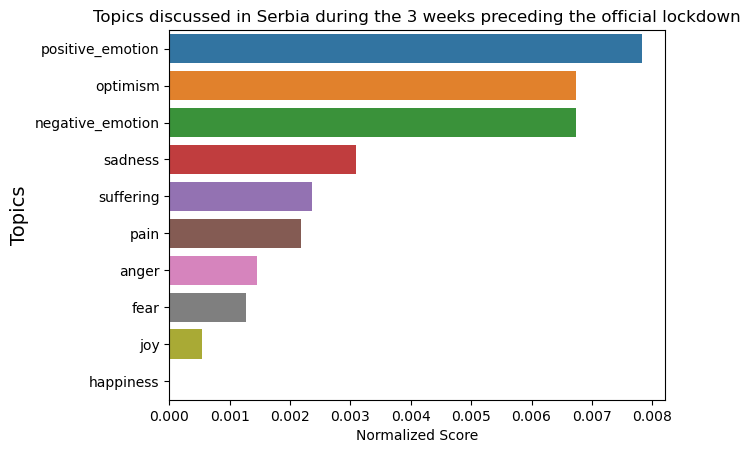

In [20]:
# Plotting dominating emotions in tweets in Serbia and Italy 3 weeks precedign the lockdown
plotTweetsTopics('RS', 'Serbia', emotions, influential_people_tweets)
plotTweetsTopics('RS', 'Serbia', emotions, influential_people_tweets)

As next step in our analysis, we want to find most used words in tweets in different countries. As an example we are plotting most used words in tweets of Serbian and Italian influencing Twitter users.

In [21]:
from collections import Counter

def plotMostCommonWords(country_code, country_name, influential_people_tweets):
    """
    Function which plot most common words in tweets of country
    
    Arguments:
        country_code: code of country from which we are retrieving tweets
        country_name: name of country from which we are retrieving tweets
        influential_people_tweets: dataframe with tweets
    Returns:
        most_common_words: list of most common words in tweeets
        all_words: all words from the tweets
    """
    
    # spliting text on words removing stop words, and looking only to nouns and verbs
    lemmatizer = WordNetLemmatizer()
    tweets_from_country = influential_people_tweets.loc[influential_people_tweets['country_code']==country_code, 
                                                        'tweet_text_en']
    all_words = ("".join(tweets_from_country.str.cat(sep = ' '))).split()
    all_words = [lemmatizer.lemmatize(term) for term in all_words 
                 if (term not in stopwords.words('english')) and 
                 (nltk.pos_tag([term])[0][1] == 'NN' or nltk.pos_tag([term])[0][1] == 'VB')]

    # ten most common words
    most_common_words = Counter(all_words).most_common(10)

    words = list(dict(most_common_words).keys())
    counts = list(dict(most_common_words).values())

    plt.xlabel('Most used words', fontsize = 12)
    plt.ylabel('Count', fontsize = 12)
    plt.xticks(rotation = 90)
    plt.title('Most used words in influencing people tweets from '+ country_name)
    plt.bar(range(len(words)), counts, tick_label=words)
    plt.show()
    
    return most_common_words, all_words

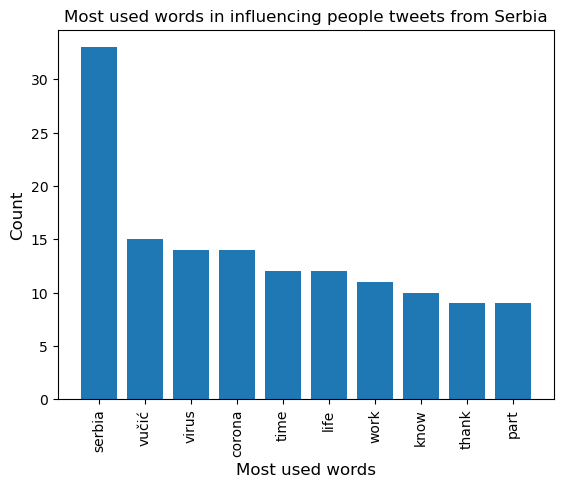

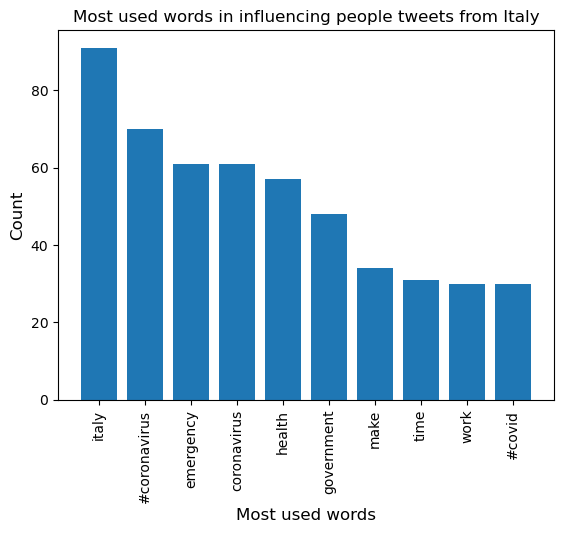

In [22]:
# plotting most common words in Serbian and Italian tweets
most_common_words_sr, all_words_sr = plotMostCommonWords('RS', 'Serbia', influential_people_tweets)
most_common_words_it, all_words_it = plotMostCommonWords('IT', 'Italy', influential_people_tweets)

Similarly, let us find most used hashtags in tweets in different countries. As an example we are plotting most used hashtags in tweets of Serbian and Italian influencing Twitter users.

In [23]:
def plotMostCommonHashtags(country_name, all_words):
    """
    Function which plot most common hashtags in tweets of country
    
    Arguments:
        country_code: code of country from which we are retrieving tweets
        country_name: name of country from which we are retrieving tweets
        influential_people_tweets: dataframe with tweets
    Returns:
        most_common_hashtags: list of most common words in tweeets
    """
    #finding most common hashtags
    hashtags = [word for word in all_words if ('#' in word)]
    most_common_hashtags = Counter(hashtags).most_common(10)

    hashtags = list(dict(most_common_hashtags).keys())
    counts = list(dict(most_common_hashtags).values())

    plt.xlabel('Most used hashtags', fontsize = 12)
    plt.ylabel('Count', fontsize = 12)
    plt.xticks(rotation = 90)
    plt.title('Most used hashtags in influencing people tweets from ' + country_name)
    plt.bar(range(len(hashtags)), counts, tick_label=hashtags)
    plt.show()
    
    return most_common_hashtags

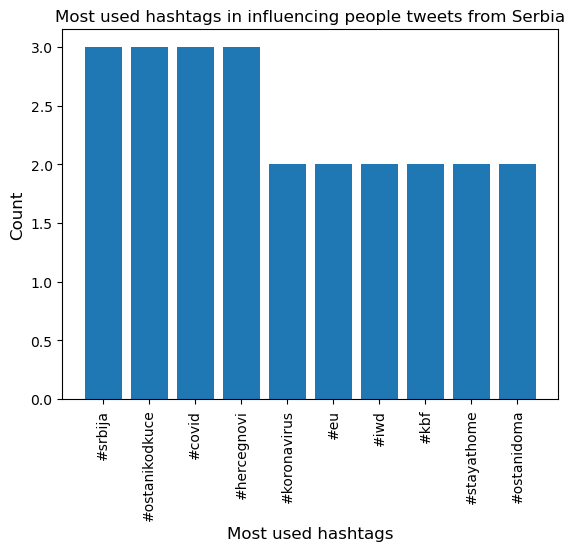

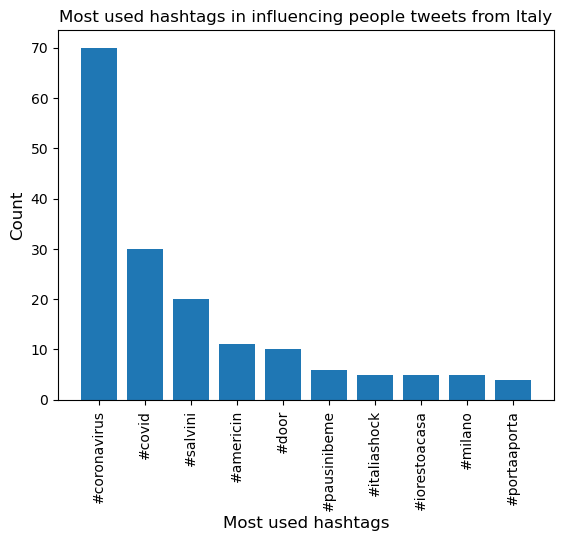

In [24]:
# plotting most common hashtags in Serbia and Italy
most_common_hashtags_sr = plotMostCommonHashtags('Serbia', all_words_sr)
most_common_hashtags_it = plotMostCommonHashtags('Italy', all_words_it)

Since hashtags are sometime composed from multiple words, and it is difficult to translate it using some libraries, we are doing it manually and plotting again. Again, we are doing this for Serbia and Italy as an example. 

In [27]:
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

def imgHashtags(hashtags):
    """
    Function which shows most common hashtags 
    
    Arguments:
        hashtags: dict of hashtags
    """
    wc = WordCloud(background_color='white').generate_from_frequencies(dict(hashtags))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

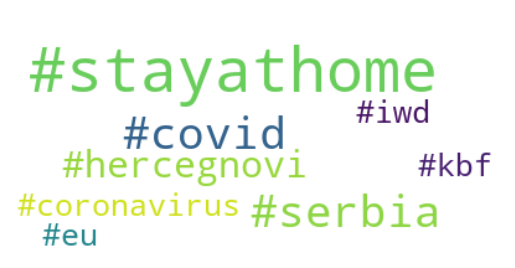

In [28]:
# show most common hashtags in Serbia in english
most_common_hashtags_RS = { '#serbia': 3, '#stayathome': 7, '#covid': 3, 
                           '#hercegnovi': 3, '#coronavirus': 2, '#eu': 2,
                           '#iwd': 2, '#kbf': 2 }

imgHashtags(most_common_hashtags_RS)

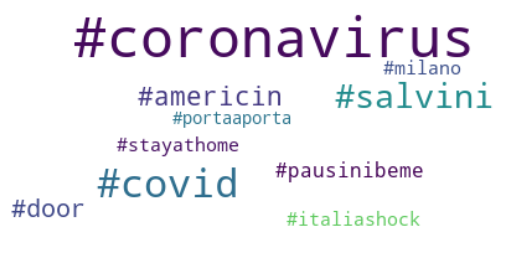

In [29]:
# show most common hashtags in Italy in english
most_common_hashtags_IT = {'#coronavirus': 70, '#covid': 30, '#salvini': 20,
 '#americin': 11, '#door': 10,'#pausinibeme': 6, '#italiashock': 5,
 '#stayathome': 5, '#milano': 5, '#portaaporta': 4}

imgHashtags(most_common_hashtags_IT)

As last step in initial analysis of tweets of influencing people from different countries, we are defining function which calculate tweet sentiment to give us more infomarion about tweets in one coutry. Even if we are not going to use it now, we define these helpers function that might help us n task 3.

In [30]:
# sentiment analysis using TextBlob
from textblob import TextBlob 

def tweetSentiment(data):
    text_sentiment = TextBlob(data).sentiment
    return text_sentiment.polarity, text_sentiment.subjectivity

In [31]:
for index, row in influential_people_tweets.iterrows():
    tweet = str(row['tweet_text_en'])
    polarity, subjectivity = tweetSentiment(tweet)   
    print(tweet, "==>", polarity, "-" ,subjectivity)
    break

we are proud of our friendship we will never forget the help of our chinese friends ==> 0.4 - 0.5


#### Conclusion & future steps

From the subset of data we retrieved so far, we can conclude that in both countries influencial people started to spread a word about covid, and to warn population to #stayathome. 

We are planning to use some of these data to compute attention score in the next task.  

<br/>
<br/>
<br/>
<br/>
